In [1]:
# Mutations in SF3B1 lead to different branch point usage, resulting in cryptic 3' splice site selection/
# This neural network was designed to predict splice sites
# sensitive to cryptic mutant-SF3B1 splicing based off sequence features. Paper mentioned below.
# Tested against a logistic regression to see if the deep learning architecture was necessary.

# Darman, R. B. et al (2015). Cancer-Associated SF3B1 Hotspot Mutations Induce Cryptic 3' Splice Site Selection through Use of a Different Branch Point. 
# Cell reports, 13(5), 1033–1045. https://doi.org/10.1016/j.celrep.2015.09.053

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import logomaker
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import GridSearchCV
from torch.utils.data import Dataset, DataLoader
from skorch import NeuralNetClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


Matplotlib is building the font cache; this may take a moment.


In [3]:
# Including the basic MaxEnt model code here. Below is original paper. 
# Yeo, G., & Burge, C. B. (2004). Maximum entropy modeling of short sequence motifs with applications to RNA splicing signals. 
# Journal of computational biology : a journal of computational molecular cell biology, 11(2-3), 377–394. https://doi.org/10.1089/1066527041410418

# One would need to train their own MaxEnt, I did so using code from https://github.com/kmccue/smsplice, from the paper below.
# Kayla McCue, Christopher B. Burge. An interpretable model of pre-mRNA splicing for animal and plant genes.Sci. 
# Adv.10,eadn1547(2024).DOI:10.1126/sciadv.adn1547

# This code computes probabilities for 5' and 3' splice site sequences. Training the model is a different script.

def base_int(base):
    if base == 'a': return 0
    elif base == 'c': return 1
    elif base == 'g': return 2
    elif base == 't': return 3
    else:
        return -1
        
def hash_seq(seq):
    sum = 0 
    l = len(seq)
    for i in range(l):
        sum += (4**(l-i-1))*base_int(seq[i])
    return sum

def maxEnt5(seq):

    # Get all the 5'SS maxent scores for the input sequence
    maxEntDir = '/Users/nrk/Desktop/PhD/Database/SpliceSites/MaxEnt_Prob/'

    prob = np.load(maxEntDir + 'maxEnt5_prob.npy')
    prob0 = np.load(maxEntDir + 'maxEnt5_prob0.npy')
    
    seq = seq.lower()
    if len(seq) == 9:
        sequence5 = np.array([hash_seq(seq)])
        scores = np.log2(prob[sequence5]) - np.log2(prob0[sequence5])
        
        return scores[0]
        
    else:
        return print('Sequence is not 9 nt')
        
def maxEnt3(seq):
    
    maxEntDir = '/Users/nrk/Desktop/PhD/Database/SpliceSites/MaxEnt_Prob/'

    # Get all the 3'SS maxent scores for the input sequence
    prob0 = np.load(maxEntDir + 'maxEnt3_prob0.npy')
    prob1 = np.load(maxEntDir + 'maxEnt3_prob1.npy')
    prob2 = np.load(maxEntDir + 'maxEnt3_prob2.npy')
    prob3 = np.load(maxEntDir + 'maxEnt3_prob3.npy')
    prob4 = np.load(maxEntDir + 'maxEnt3_prob4.npy')
    prob5 = np.load(maxEntDir + 'maxEnt3_prob5.npy')
    prob6 = np.load(maxEntDir + 'maxEnt3_prob6.npy')
    prob7 = np.load(maxEntDir + 'maxEnt3_prob7.npy')
    prob8 = np.load(maxEntDir + 'maxEnt3_prob8.npy')
    
    prob0_0 = np.load(maxEntDir + 'maxEnt3_prob0_0.npy')
    prob1_0 = np.load(maxEntDir + 'maxEnt3_prob1_0.npy')
    prob2_0 = np.load(maxEntDir + 'maxEnt3_prob2_0.npy')
    prob3_0 = np.load(maxEntDir + 'maxEnt3_prob3_0.npy')
    prob4_0 = np.load(maxEntDir + 'maxEnt3_prob4_0.npy')
    prob5_0 = np.load(maxEntDir + 'maxEnt3_prob5_0.npy')
    prob6_0 = np.load(maxEntDir + 'maxEnt3_prob6_0.npy')
    prob7_0 = np.load(maxEntDir + 'maxEnt3_prob7_0.npy')
    prob8_0 = np.load(maxEntDir + 'maxEnt3_prob8_0.npy')
    
    seq = seq.lower()
    
    if len(seq) == 23:
        
        hash0 = np.array([hash_seq(seq[0:7])])
        hash1 = np.array([hash_seq(seq[7:14])])
        hash2 = np.array([hash_seq(seq[14:])])
        hash3 = np.array([hash_seq(seq[4:11])])
        hash4 = np.array([hash_seq(seq[11:18])])
        hash5 = np.array([hash_seq(seq[4:7])])
        hash6 = np.array([hash_seq(seq[7:11])])
        hash7 = np.array([hash_seq(seq[11:14])])
        hash8 = np.array([hash_seq(seq[14:18])])
        
        probs = np.log2(prob0[hash0]) + np.log2(prob1[hash1]) + np.log2(prob2[hash2]) + \
                np.log2(prob3[hash3]) + np.log2(prob4[hash4]) - np.log2(prob5[hash5]) - \
                np.log2(prob6[hash6]) - np.log2(prob7[hash7]) - np.log2(prob8[hash8]) - \
                (np.log2(prob0_0[hash0]) + np.log2(prob1_0[hash1]) + np.log2(prob2_0[hash2]) + \
                np.log2(prob3_0[hash3]) + np.log2(prob4_0[hash4]) - np.log2(prob5_0[hash5]) - \
                np.log2(prob6_0[hash6]) - np.log2(prob7_0[hash7]) - np.log2(prob8_0[hash8]))
    
        scores = probs[0]
        
        return scores

    else:
        
        return print('Sequence is not 23 nt')

# Train-test split of intronic sequences.
# Pull the sequences you want to train and test on.

DataBase = '/Users/nrk/Desktop/PhD/Database/SpliceSites/'

# 172k
with open(DataBase + 'train3_true.txt') as f: positive_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 3.4m. A random subset of this will go into the test set, too large.
with open(DataBase + 'train3_null.txt') as f: negative_train = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 12k
with open(DataBase + 'test3_true.txt') as f: positive_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])
# 240k
with open(DataBase + 'test3_null.txt') as f: negative_test = list([i.upper() for i in f.read().splitlines() if len(i) == 50])

# Heuristic PPT Model to predict polypyrimidine tract features
# Feature 1: Both 3′ and 5′ ends must be pyrimidines
# Feature 2: No more than three continuous purines are allowed
# Feature 3: Minimum length of 5 nucleotides
# Feature 4: Uridine content greater or equal to 80%.

def heuristic_ppt(sequence):
    
    pyr_pur = sequence.translate(str.maketrans('TCAG', 'YYRR'))

    # Atleast 6 nt long...
    best_ppt = np.zeros((3))
    best = 6
    
    for start_index in range(len(pyr_pur)):
        
        # Looking at windows of atleast 6 nt
        for end_index in range(start_index+1,len(pyr_pur)+1):
            subsequence = pyr_pur[start_index:end_index]
            
            # Starts and ends with pyrimidine
            if subsequence[0] == 'Y' and subsequence[-1] == 'Y':
                
                # No triple purine
                if 'RRR' not in subsequence:
                    
                    # Over a certain % pyrimidine
                    if subsequence.count('Y')/len(subsequence) >= 0.8 :
                        
                        # Favors the earliest PPT
                        if len(subsequence) >= best:
                            best = len(subsequence)
                            best_ppt = [best, start_index, end_index]
                            
    return best_ppt
    

In [ ]:
# Dataframe of mutant SF3B1 sequences, Supplemental Information 2 from the paper.

sf3b1 = pd.read_excel('mmc3.xls', header = 1)

# CoLa-seq branch point sequences mapped to their respective 3' splice sites. I will upload this file.
# Zeng, Y. et al (2022). Profiling lariat intermediates reveals genetic determinants of early and late co-transcriptional splicing. 
# Molecular cell, 82(24), 4681–4699.e8. https://doi.org/10.1016/j.molcel.2022.11.004
# PWM for BPS from CoLa-seq

with open('introns_w_cola_bps.pkl', 'rb') as file: 
      
    bps = pickle.load(file)

pwm_bps = logomaker.alignment_to_matrix([str(i.seq.upper())[:7] for i in bps if len(i.seq) > 10 and len(i.seq) < 70], to_type='probability')

# Canonical 3' splice sites, WT SF3B1 splicing control

true3_train = random.sample([i.upper()[-40:] for i in positive_train if i[-5:-3] == 'AG'], 875)


In [14]:
model_features = np.zeros((2, 875, 10))

# Feature vector: 0: PPT length, 1: sequence A%, 2: sequence C%, 3: sequence G%, 
# 4: sequence T%, 5: BPS strength past 10 nt, 6: 3' splice site strength, 
# 7: distance between branch point and PPT, 8: distance between PPT and 3’ splice site, 
# 9: distance between branch point and 3’ splice site

sensitive = sf3b1[sf3b1['Intron retention'] == False]['Canonical junction sequence']

for subset, sub in enumerate([sensitive, true3_train]):
   
    for samp, seq in enumerate(sub):
        
        ppt = heuristic_ppt(seq)
        four_nt = np.zeros((4))

        for ind, nt in enumerate(['A', 'C', 'G', 'T']):
            four_nt[ind] = seq.count(nt)
            
        model_features[subset, samp, 0] = ppt[0]
        model_features[subset, samp, 1:5] = four_nt / len(seq)
        
        # BPS search
        maxi = 0
        
        # Add a 'C' to the end because there are sequences without C.
        
        seq_array = np.array(logomaker.alignment_to_matrix([seq + 'ACGT']))

        for ind, i in enumerate(range(0, 27)):

            temp = np.prod(np.sum(seq_array[i:i+7] * pwm_bps, axis=1))

            if temp > maxi:
                maxi = temp
                bps_ind = ind
                
        model_features[subset, samp, 5] = maxi
        model_features[subset, samp, 6] = maxEnt3(seq[-23:])
        model_features[subset, samp, 7] = len(seq) - ppt[1]
        model_features[subset, samp, 8] = ppt[2]
        model_features[subset, samp, 9] = len(seq) - bps_ind

# Creating the finalized feature vector and prediction classes for training
X = np.concatenate((model_features[0], model_features[1]))
y = [0] * 875 + [1] * 875

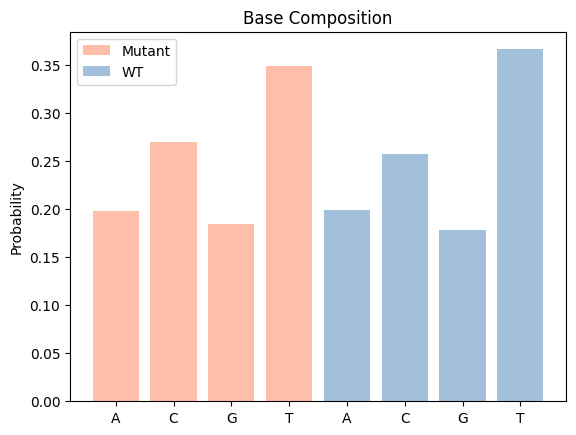

In [29]:
# Example feature difference between SF3B1 mutants and wild-type

mutant_means = [np.mean(X[:875, i]) for i in range(1, 5)]
wt_means = [np.mean(X[875:, i]) for i in range(1, 5)]

plt.bar(range(4), mutant_means, color='coral', label='Mutant', alpha = 0.5)
plt.bar(np.arange(4, 8), wt_means, color='steelblue', label='WT', alpha = 0.5)
plt.title('Base Composition')
plt.xticks(np.arange(8), ['A', 'C', 'G', 'T', 'A', 'C', 'G', 'T'])
plt.ylabel('Probability')
plt.legend()
plt.show()


In [ ]:
# Dataset to input into model

class CustomDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

# MLP Model

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, activation=nn.ReLU()):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(activation)
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
        layers.append(nn.Linear(hidden_size, 1))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        output = torch.sigmoid(self.model(x))
        return output.squeeze(1)


# Create an MLP model instance for gridsearch

def create_model(input_size=10, hidden_size=128, num_layers=2, activation=nn.ReLU(), optimizer=optim.Adam, lr=0.001):
    return NeuralNetClassifier(
        module=MLP(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, activation=activation),
        criterion=nn.BCELoss,
        optimizer=optimizer,
        lr=lr,
        max_epochs=10,
        batch_size=32,
        iterator_train__shuffle=True,
        verbose=False
    )

# Grid search hyperparameters

param_grid = {
    'module__input_size': [10],
    'module__hidden_size': [128, 256, 512],
    'module__num_layers': [1, 2, 3],
    'module__activation': [nn.ReLU(), nn.LeakyReLU()],
    'optimizer': [optim.Adam, optim.SGD],
    'lr': [0.1, 0.01]
}

grid_search = GridSearchCV(create_model(), param_grid, scoring='roc_auc', cv=5, verbose=1)

# Scale features

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

# Training and test split, input into dataset, and grid search

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1)
dataset = CustomDataset(X_train, y_train)
grid_search.fit(dataset.X, dataset.y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


In [ ]:
# Logistic regression as a control model to test against.
# Training and test split, input into dataset, and grid search

outi = grid_search.predict_proba(CustomDataset(X_test, y_test))
print('Grid Search:', roc_auc_score(y_test, [i[1] for i in outi]))

clf = LogisticRegression().fit(X_train, y_train)
output = clf.predict_proba(X_test)
print('Logistic Regression:', roc_auc_score(y_test, [i[1] for i in output]))


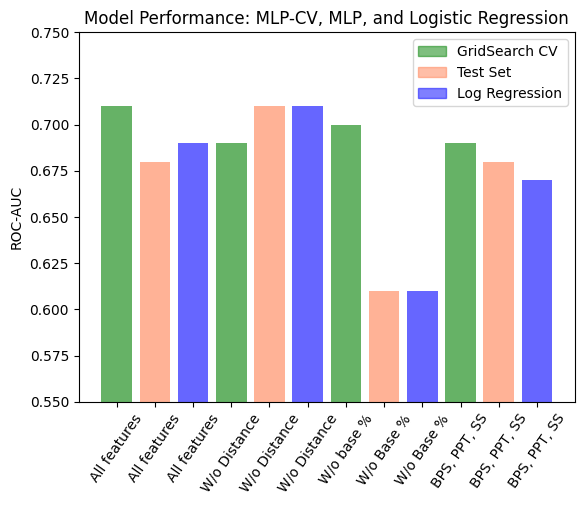

In [49]:
# Different MLP architectures and their respective scores from the original project. 
# Feature importance by removing features and observing the effect on ROC-AUC.

'''
Best Hyperparameters: {'lr': 0.001, 'module__activation': LeakyReLU(negative_slope=0.01), 'module__hidden_size': 512, 'module__input_size': 10, 'module__num_layers': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Score: 0.7145097357632783 

2. W/o distance features

Best Hyperparameters: {'lr': 0.001, 'module__activation': LeakyReLU(negative_slope=0.01), 'module__hidden_size': 512, 'module__input_size': 7, 'module__num_layers': 4, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Score: 0.6940176648954391

3. w/o bases

Best Hyperparameters: {'lr': 0.001, 'module__activation': LeakyReLU(negative_slope=0.01), 'module__hidden_size': 256, 'module__input_size': 6, 'module__num_layers': 3, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Score: 0.701389253022801

4. w/o bases and dist features

Best Hyperparameters: {'lr': 0.001, 'module__activation': LeakyReLU(negative_slope=0.01), 'module__hidden_size': 256, 'module__input_size': 3, 'module__num_layers': 4, 'optimizer': <class 'torch.optim.adam.Adam'>}
Best Score: 0.687137098831573'''

labels = ['GridSearch CV', 'Test Set', 'Log Regression']
colors = ['green', 'coral', 'blue']
plt.bar(range(12), [0.71, 0.68, 0.69, 
0.69, 0.71, 0.71, 
0.70, 0.61, 0.61,
0.69, 0.68, 0.67], color = colors, alpha = 0.6)
plt.ylim([0.5,1])
plt.title('Model Performance: MLP-CV, MLP, and Logistic Regression')
legend_patches = [plt.Rectangle((0,0),1,1, color=color, alpha=0.5) for color in colors]
plt.legend(legend_patches, labels)
plt.ylabel('ROC-AUC')
plt.xticks(range(12), ['All features', 'All features', 'All features', 'W/o Distance', 
                       'W/o Distance', 'W/o Distance',  'W/o base %', 
                       'W/o Base %', 'W/o Base %', 'BPS, PPT, SS', 
                       'BPS, PPT, SS', 'BPS, PPT, SS'], rotation = 55)
plt.ylim([0.55,0.75])
plt.show()